In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from itertools import combinations
import statistics
import math

In [3]:
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/Asian_site_ard2.csv')
dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_NSR.csv')
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_SR.csv')
dataframe = dataframe[dataframe["Coincidence"] < 1].reset_index()
dataframe = dataframe.drop(columns=["index"])
dataframe = dataframe[dataframe['Salinity']>20]

In [4]:
tempdf = pd.DataFrame()
tempdf['Tmean'] = dataframe[['pH','Salinity','Ammonia']].mean()
tempdf['Tstd'] = dataframe[['pH','Salinity','Ammonia']].std()
for date in dataframe['Date of Image'].unique():
  df = dataframe.loc[dataframe['Date of Image'] == date]
  tempdf[f'{date}_mean'] = df[['pH','Salinity','Ammonia']].mean()
  tempdf[f'{date}_std'] = df[['pH','Salinity','Ammonia']].std()

In [5]:
tempdf

,Tmean,Tstd,2022-07-14_mean,2022-07-14_std,2022-09-12_mean,2022-09-12_std,2023-04-25_mean,2023-04-25_std,2023-05-30_mean,2023-05-30_std,2023-07-09_mean,2023-07-09_std
pH,8.205357,0.361522,8.600,0.106904,8.43750,0.170783,7.6250,0.150000,7.900000,0.264575,8.166667,0.276887
Salinity,33.678571,6.390638,37.875,1.807722,35.56250,3.898183,26.0000,3.366502,24.923077,1.754116,39.066667,2.051712
Ammonia,0.043750,0.032784,0.000,0.000000,0.02625,0.015438,0.0275,0.009574,0.074615,0.025038,0.063333,0.024398


In [6]:
dataframe.head()

,PondID,pH,Salinity,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium,Ammonia,...,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,TUPILIPALEM_A2,8.4,35,30,120,150,6300,388,1296,0.0,...,612,1253,1154,919,1025,1059,1171,920,1188,165
1,TUPILIPALEM_A3,8.7,38,40,120,160,6800,472,1471,0.0,...,484,1179,1065,794,854,918,1042,737,993,131
2,TUPILIPALEM_A4,8.7,39,40,110,150,6960,482,1488,0.0,...,432,1114,969,708,779,727,825,641,897,170
3,TUPILIPALEM_A5,8.7,40,40,120,160,7100,488,1491,0.0,...,524,1127,950,798,734,844,963,614,952,157
4,TUPILIPALEM_B2,8.6,36,50,110,160,6200,378,1302,0.0,...,710,1236,1162,1108,1114,1217,1268,828,1254,169


In [7]:
print("pH Minimum Value:", dataframe["pH"].min())
print("Salinity Minimum Value:", dataframe["Salinity"].min())

pH Minimum Value: 7.5
Salinity Minimum Value: 22


In [8]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
wavelengths = [442.7,	492.4,559.8,664.6,704.1,740.5,782.8,832.8,864.7,945.1,1373.5,1613.7,2202.4]
parameters = ["pH", "Salinity", "Ammonia"]

In [9]:
dataframe[["pH", "Salinity", "Ammonia"]].std()/np.array([8.5, 45, 0.5])

pH          0.042532
Salinity    0.142014
Ammonia     0.065567
dtype: float64

## WQI calculation

In [10]:
# def derivative(dataframe):
#     banddata = dataframe[bands]
#     for wave,band in (wavelengths,bands):



#     return None

def calculateWQI(parameters):
    # order of parameters ph salinity ammonia
    expdf = pd.DataFrame()
    permissibleValuesParameters = np.array([8.5, 45, 0.5])
    summ = 0
    sumWn = 0
    weights =   np.array([0.3,0.30,0.4]) # np.array(parameters.std()/permissibleValuesParameters)
    weightsnormalized = weights/sum(weights)
    for column, sn, Wn in zip(parameters.columns, permissibleValuesParameters, weightsnormalized):
        vn = parameters[column]
        if column=="pH":
            vid = 7.5
        elif column=="Salinity":
            vid = 15
        else:
            vid = 0.0
        qn = 100*(vn - vid)/(sn-vid)

        summ = summ + (qn*Wn)
        sumWn = sumWn + Wn
    expdf['summ'] = summ
    expdf['qn'] = qn
    WQI = summ/sumWn
    return WQI,expdf

def bandmath(bandMatrix,WQI):
  df = pd.DataFrame()
  cc = list(combinations(bandMatrix.columns,2))
  print(cc)
  for combination in cc:
    a = combination[0]
    b = combination[1]
    diffIndex = bandMatrix[a] - bandMatrix[b]
    normlizedIndex = (bandMatrix[a] - bandMatrix[b])/bandMatrix[a] + bandMatrix[b]
    ratioIndex = bandMatrix[a] / bandMatrix[b]
    df[f'diff_{a}_{b}'] = diffIndex
    df[f'norm_{a}_{b}'] = normlizedIndex
    df[f'ratio_{a}_{b}'] = ratioIndex
  df['WQI_cal'] = WQI
  return  df

def pca(data):
  pca = PCA(n_components=3)
  pca.fit(data)
  pca_data =  pca.transform(data)
  return  pca_data

def harmonizedWQIcalculation(GT):
  min = np.array([7.5,9,0])
  max = np.array([8.7,43,0.12])
  permissibleWP = np.array([8.5,45,0.5])
  weights =  np.array(GT.std()/permissibleWP)
  weights_norm = weights/sum(weights)
  numP = len(weights_norm)
  rr = max - min
  allWQI  = np.array([])
  n = len(GT)
  for val in GT.values:
    i = 0
    Tsumm = np.array([])
    for para in val:
        qi =None
        summ = 0
        if  min[i] <= para  <= 0.10*rr[i]:
          qi = 5
        if  0.1*min[i] <= para  <= 0.20*rr[i]:
          qi = 15
        if  0.20*rr[i] <= para  <= 0.30*rr[i]:
          qi = 25
        if  0.30*rr[i] <= para  <= 0.40*rr[i]:
          qi = 35
        if  0.40*rr[i] <= para  <= 0.50*rr[i]:
          qi = 45
        if  0.50*rr[i] <= para  <= 0.60*rr[i]:
          qi = 55
        if  0.60*rr[i] <= para  <= 0.70*rr[i]:
          qi = 65
        if  0.70*rr[i] <= para  <= 0.80*rr[i]:
          qi = 75
        if  0.80*rr[i] <= para  <= 0.90*rr[i]:
          qi = 85
        if  0.90*rr[i] <= para  <= max[i]:
          qi = 95
        # print(qi,para,rr[i])
        summ += 1/qi
        i+=1
        Tsumm = np.append(Tsumm,summ)
    WQI = sum([(weights_norm[i])*math.sqrt(i+1/Tsumm[i]**2) for i in range(numP)])/numP
    allWQI = np.append(allWQI,WQI)

  return allWQI


(array([ 2.,  4.,  4.,  2.,  7.,  4.,  6., 10., 12.,  5.]),
 array([10.2 , 15.64, 21.08, 26.52, 31.96, 37.4 , 42.84, 48.28, 53.72,
        59.16, 64.6 ]),
 <BarContainer object of 10 artists>)

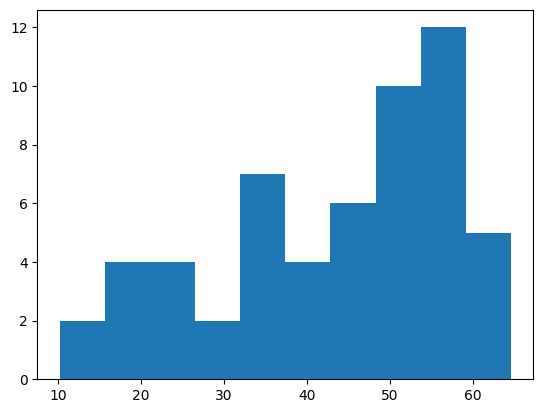

In [11]:
wqi,expdf= calculateWQI(dataframe[parameters])
## plotting distribution of wqi
plt.hist(wqi)

In [12]:

## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(wqi))
print("Standard Deviation WQI", statistics.stdev(wqi))

Mean WQI 43.33928571428571
Standard Deviation WQI 14.363383731133558


## Model for the WQI to indiviual parameter

In [13]:
def CM(actual, predicted):
  fig = plt.figure()
  plt.scatter(actual, predicted)
  plt.show()

def Presults(y_test, prediction):
  print("MAE", mean_absolute_error(y_test, prediction))
  print("MSE", mean_squared_error(y_test, prediction))
  print("RMSE", mean_squared_error(y_test, prediction, squared=False))
  print("MAPE", mean_absolute_percentage_error(y_test, prediction))
  print("R2 Score", r2_score(y_test, prediction))
  # return model.coef_,model.intercept_

def LRegression(dataframe,index,name,WQI_val,GT_val,scaler):
  CM(dataframe[name],dataframe[index])
  # for i ,j in zip(dataframe[index],WQI_val):
  #   print(i,j)
  # dataframe[index] = scaler.inverse_transform(np.array(dataframe[index]).reshape(-1, 1))
  # WQI_val = scaler.inverse_transform(np.array(WQI_val).reshape(-1, 1))
  # for i ,j in zip(dataframe[index],WQI_val):
  #   print(i,j)

  validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
  traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]
  # print(WQI, GT)

  xTrain = np.array((traindataframe[index])).reshape(-1, 1)
  yTrain = traindataframe[name]
  xTest = np.array((validationdataframe[index])).reshape(-1, 1)
  yTest = validationdataframe[name]
  # X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
  # model = LinearRegression().fit(xTrain, yTrain)
  # # model = SVR(kernel='rbf', C=2.0, epsilon=0.2).fit(xTrain, yTrain)
  # if name == 'Ammonia':
  #   # print('hi')
  model = RandomForestRegressor(max_depth=2, random_state=0).fit(xTrain, yTrain)
  prediction = model.predict(xTest)
  prediction_val = model.predict(WQI_val)
  for x,y in zip(yTest.values,prediction):
    print(x,'-',y)
  Presults(yTest, prediction)
  print(f"validation results on {name}")
  Presults(GT_val,prediction_val)
  for x,y in zip(GT_val,prediction_val):
    print(x,'-',y)
  print(f"---------------------------------------")


#to predict the parameters from WQI



def WQIandParameters(dataframe,index,predictedWQI,gtforRE,scaler):
  print('-----For WQI with pH Regression relation-----')
  LRegression(dataframe,index,'pH',predictedWQI,gtforRE['pH'],scaler)
  print('-----For WQI with Salinity  Regression relation-----')
  LRegression(dataframe,index,'Salinity',predictedWQI,gtforRE['Salinity'],scaler)
  print('-----For WQI with Ammonia SVR relation-----')
  LRegression(dataframe,index,'Ammonia',predictedWQI,gtforRE['Ammonia'],scaler)
  return None



In [14]:
### adding wqi as a dataframe

dataframe["WQI"] = wqi
# print(wqi)
scaler2 = MinMaxScaler()
dataframe['WQI'] = scaler2.fit_transform(dataframe[['WQI']]).flatten()
# print(dataframe['WQI'])

In [15]:
# sns.pairplot(dataframe)

## Model for Band to WQI index

In [16]:

def scaling(Banddata):
    scaler = StandardScaler()
    scaler.fit(Banddata)
    dataframe = scaler.transform(Banddata)
    return dataframe

def pca(dataframe):
  pca = PCA(n_components=3)
  pca.fit(dataframe)
  pca_df =  pca.transform(dataframe)
  return pca_df

# def weakmodel(xTrain, yTrain,xTest):
#       models = [
#         RandomForestRegressor(max_depth=3, random_state=0),
#         xgb.XGBRegressor(),
#         SVR(kernel='rbf', C=1.0, epsilon=1e-3)]

#       preds = []
#       for i, m in enumerate(models):
#           m.fit(xTrain, yTrain)
#           preds.append(m.predict(xTest))

#       weights = [0.33, 0.33,0.33]
#       preds = np.array(preds)
#       print
#       preds= np.sum(preds, axis = 0)/3
#       return preds

### model to predict WQI using bands as input
def predictWQI(dataframe,pred):
    # validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
    # traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

    traindataframe, validationdataframe = train_test_split(dataframe, test_size=0.3, random_state=42)
    # traindataframe.to_csv('WQIModelTrain.csv')
    # validationdataframe.to_csv('WQIModelTest.csv')

    # validationdataframe = dataframe[dataframe["Date of Image"]=="2022-09-12"]
    # traindataframe = dataframe[dataframe["Date of Image"]!="2022-09-12"]
    # k =  10
    # k_fold = KFold(n_splits = k,shuffle=True )


    gtforRE = (validationdataframe[parameters])

    xTrain = (scaling(traindataframe[bands]))
    yTrain = traindataframe[pred]
    xTest = (scaling(validationdataframe[bands]))
    yTest = validationdataframe[pred]

    model = SVR(kernel='rbf', C=2.0, epsilon=1e-4)
    # model = RandomForestRegressor(max_depth=3, random_state=0)
    # model = MLPRegressor(random_state=1, max_iter=100000)

    model.fit(xTrain, yTrain)

    # score = cross_val_score(model, dataframe[bands], dataframe[pred], cv = k_fold)
    # print(sum(score) / len(score))
    # print(score)
    # prediction =  weakmodel(xTrain,yTrain,xTest)
    prediction = model.predict(xTest)
    # prediction = preds
    # print(prediction,yTest)

    print("MAE", mean_absolute_error(yTest, prediction))
    print("MSE", mean_squared_error(yTest, prediction))
    print("RMSE", mean_squared_error(yTest, prediction, squared=False))
    print("MAPE", mean_absolute_percentage_error(yTest, prediction))
    print("R2 Score", r2_score(yTest, prediction))
    plt.figure(figsize=(25,10))
    plt.scatter(np.arange(1, len(yTest)+1), yTest, color="red")
    plt.plot(np.arange(1, len(yTest)+1), prediction, color="blue")
    return prediction,gtforRE

In [17]:
(dataframe).corrwith(dataframe['WQI'])

<ipython-input-17-d8a89629dacb>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['WQI'])


pH             0.916739
Salinity       0.824501
Carbonate      0.809570
BiCarbonate   -0.060075
Alkalinity     0.200227
Hardness       0.013418
Calcium       -0.783747
Magnesium      0.785480
Ammonia       -0.323462
Coincidence         NaN
B1            -0.730466
B10           -0.336950
B11           -0.587356
B12           -0.549838
B2            -0.731258
B3            -0.671447
B4            -0.706197
B5            -0.684023
B6            -0.673379
B7            -0.668033
B8            -0.692346
B8A           -0.640661
B9            -0.467050
WQI            1.000000
dtype: float64

(array([ 2.,  4.,  4.,  2.,  7.,  4.,  6., 10., 12.,  5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

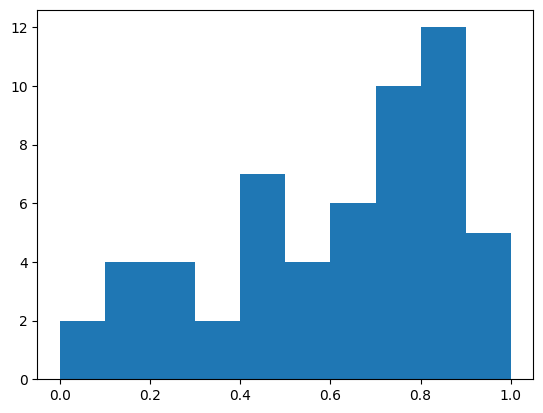

In [18]:

plt.hist(dataframe['WQI'])

MAE 0.13102919426021173
MSE 0.033983642365155865
RMSE 0.18434652794440112
MAPE 0.5910193142273392
R2 Score 0.574314011771455
0     0.676471
1     0.897059
2     0.915441
3     0.933824
4     0.805147
5     0.841912
6     0.823529
7     0.823529
8     0.845588
9     0.775735
10    0.841912
11    0.566176
12    0.705882
13    0.827206
14    0.871324
15    0.841912
16    0.672794
17    0.672794
18    0.801471
19    0.779412
20    0.562500
21    0.636029
22    0.775735
23    0.761029
24    0.000000
25    0.025735
37    0.194853
38    0.257353
39    0.470588
40    0.485294
41    0.224265
42    0.470588
43    0.470588
45    0.106618
46    0.154412
47    0.345588
48    0.393382
49    0.172794
50    0.481618
51    0.514706
52    0.941176
53    0.720588
54    0.731618
55    0.536765
56    0.437500
57    1.000000
58    0.716912
59    0.878676
60    0.650735
61    0.691176
62    0.786765
63    0.768382
64    0.937500
65    0.422794
66    0.227941
67    0.242647
Name: WQI, dtype: float64
0     47.

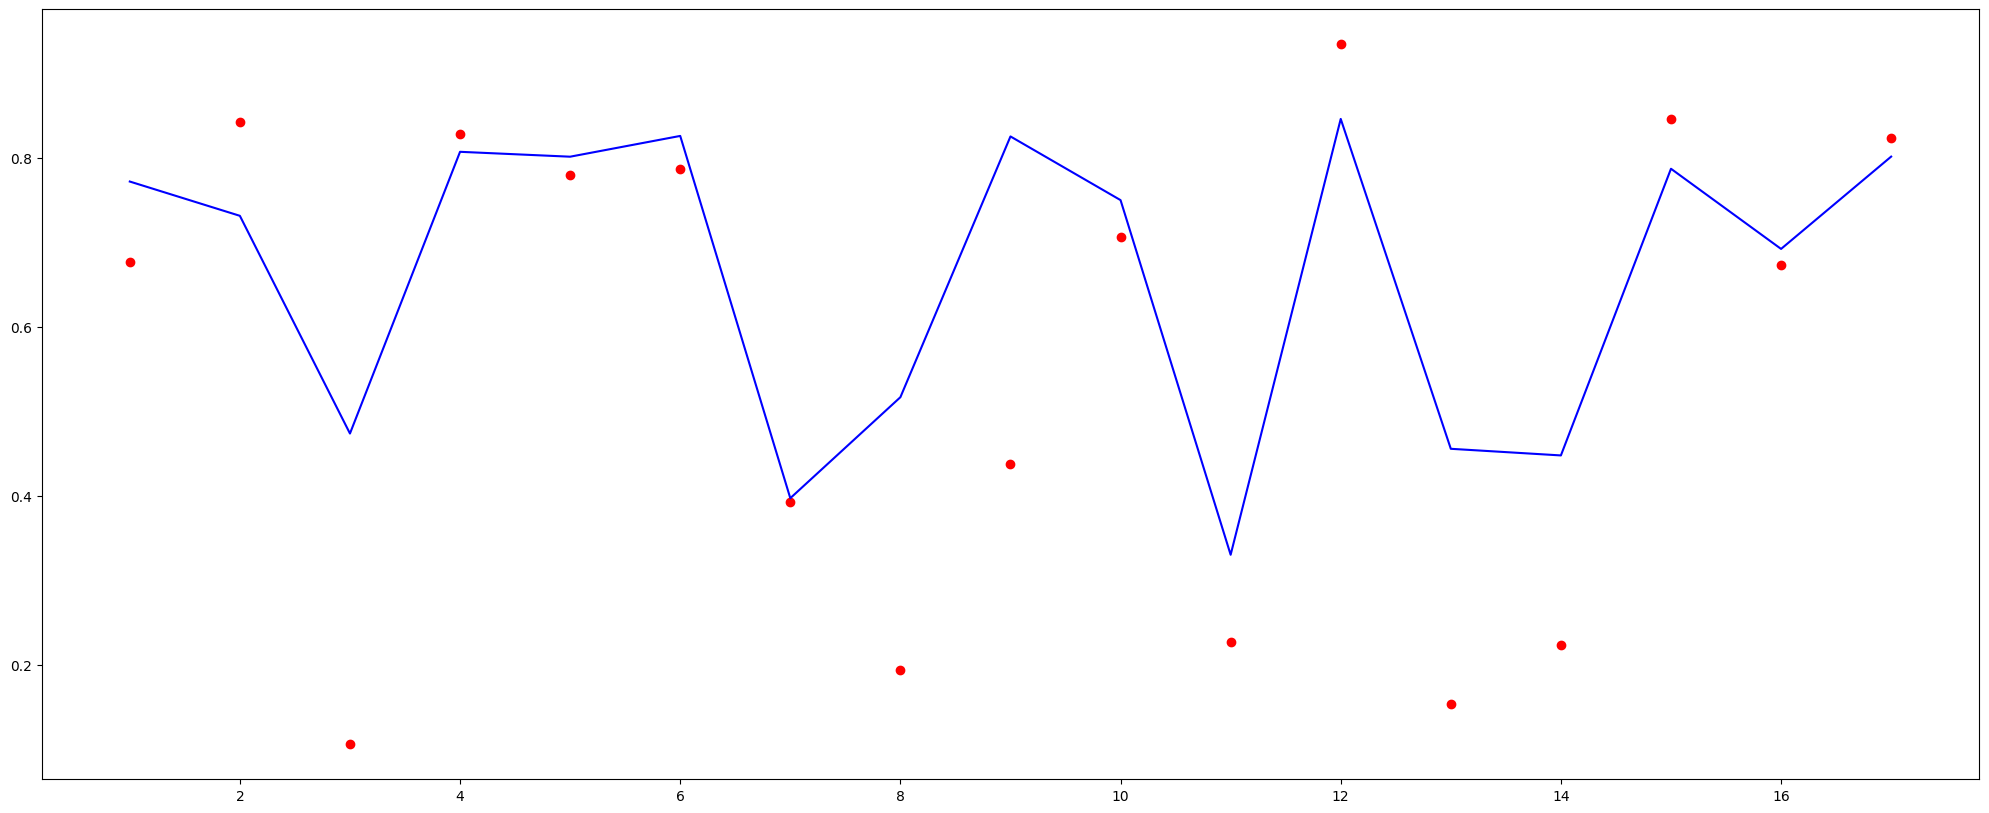

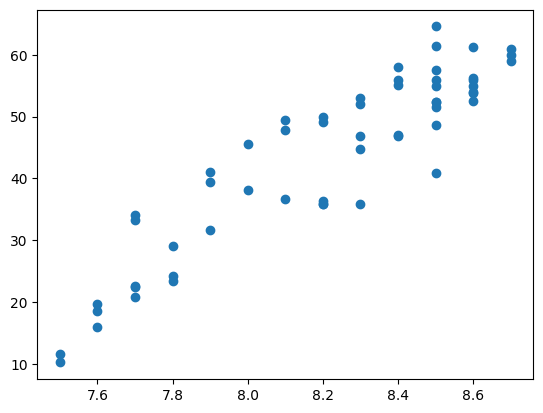

8.0 - 8.204462680753199
8.5 - 8.564144957926189
8.1 - 8.522396088744113
8.2 - 8.541455639487488
7.9 - 8.22765093572933
7.7 - 8.19532415261467
8.5 - 8.564144957926189
8.2 - 8.501081650842833
8.4 - 8.556498039828803
8.0 - 8.317732735785661
8.1 - 8.428493002947043
8.3 - 8.545506144537992
8.3 - 8.541455639487488
8.6 - 8.564144957926189
7.7 - 7.9715506895881925
MAE 0.2545168238848667
MSE 0.08102324637806925
RMSE 0.2846458262087629
MAPE 0.031597790883326024
R2 Score -0.13231244938295572
validation results on pH
MAE 0.5839454869476924
MSE 0.5122034043909375
RMSE 0.7156838718253594
MAPE 0.06899950555193636
R2 Score -1.9916488251612976
8.4 - 7.592525101287602
8.6 - 7.592525101287602
7.6 - 7.592525101287602
8.4 - 7.592525101287602
8.6 - 7.592525101287602
8.3 - 7.592525101287602
7.9 - 7.592525101287602
7.7 - 7.592525101287602
7.7 - 7.592525101287602
8.5 - 7.592525101287602
7.7 - 7.592525101287602
8.7 - 7.592525101287602
7.6 - 7.592525101287602
7.7 - 7.592525101287602
8.6 - 7.592525101287602
8.4 -

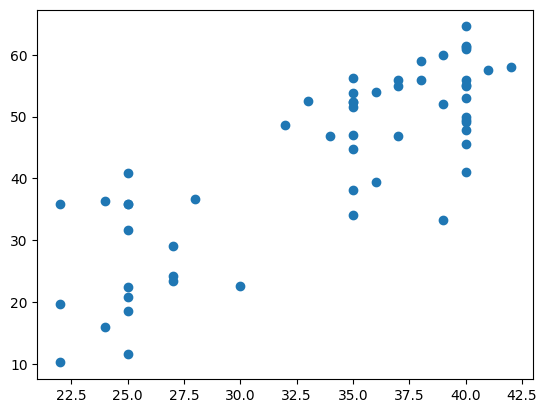

35 - 26.00475428248222
40 - 38.68624958649881
40 - 35.29066108858239
40 - 35.29066108858239
36 - 28.547191427395617
35 - 25.653084751849455
40 - 38.68624958649881
40 - 35.29066108858239
42 - 38.65860252767528
40 - 35.29066108858239
40 - 35.29066108858239
40 - 35.29066108858239
39 - 35.29066108858239
40 - 38.68624958649881
39 - 25.68710184586655
MAE 5.223725919010515
MSE 37.61507157514246
RMSE 6.133112715020201
MAPE 0.13680273464609333
R2 Score -8.573971837564539
validation results on Salinity
MAE 8.696119756877101
MSE 107.63633965639805
RMSE 10.374793475361235
MAPE 0.24291179016710937
R2 Score -2.3621813835602063
35 - 23.83329200782878
38 - 23.83329200782878
24 - 23.83329200782878
40 - 23.83329200782878
33 - 23.83329200782878
40 - 23.83329200782878
25 - 23.83329200782878
25 - 23.83329200782878
35 - 23.83329200782878
32 - 23.83329200782878
30 - 23.83329200782878
40 - 23.83329200782878
25 - 23.83329200782878
25 - 23.83329200782878
35 - 23.83329200782878
34 - 23.83329200782878
37 - 23.833

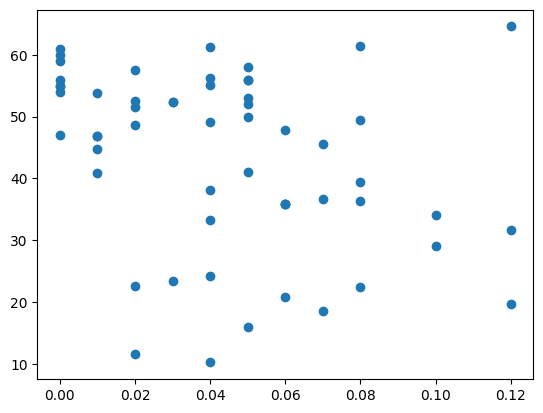

0.04 - 0.07329455117294126
0.08 - 0.008200750360750363
0.08 - 0.01713312906698901
0.05 - 0.017310271924131867
0.08 - 0.03889171592315643
0.1 - 0.07284157498246507
0.12 - 0.008200750360750363
0.04 - 0.01713312906698901
0.05 - 0.016741945551072515
0.07 - 0.01713312906698901
0.06 - 0.01713312906698901
0.05 - 0.017310271924131867
0.05 - 0.017310271924131867
0.04 - 0.008200750360750363
0.04 - 0.07284157498246507
MAE 0.04417302043840731
MSE 0.002446635270956682
RMSE 0.04946347410925239
MAPE 0.701114301725608
R2 Score -3.403943487722028
validation results on Ammonia
MAE 0.03041422087716205
MSE 0.0013028572809021535
RMSE 0.0360951143633339
MAPE 48406368341551.82
R2 Score -0.02539693404336152
0.0 - 0.04568058497058496
0.0 - 0.04568058497058496
0.05 - 0.04568058497058496
0.04 - 0.04568058497058496
0.02 - 0.04568058497058496
0.05 - 0.04568058497058496
0.12 - 0.04568058497058496
0.06 - 0.04568058497058496
0.1 - 0.04568058497058496
0.02 - 0.04568058497058496
0.02 - 0.04568058497058496
0.0 - 0.04568

In [19]:
predictedWQI,gtforRE = predictWQI(dataframe,"WQI")
# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)

print(dataframe["WQI"])

dataframe['WQI'] = scaler2.inverse_transform(dataframe[['WQI']]).flatten()
print(dataframe["WQI"])

WQIandParameters(dataframe,'WQI',predictedWQI.reshape(-1, 1),gtforRE,scaler2)

Mean WQI 0.6622530511208694
Standard Deviation WQI 0.1789234535514426


(array([1., 1., 3., 1., 0., 0., 0., 2., 3., 6.]),
 array([0.3305685 , 0.38207316, 0.43357782, 0.48508247, 0.53658713,
        0.58809178, 0.63959644, 0.6911011 , 0.74260575, 0.79411041,
        0.84561506]),
 <BarContainer object of 10 artists>)

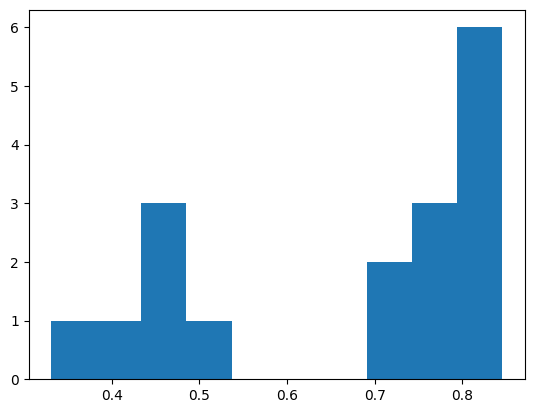

In [20]:
#
## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(predictedWQI))
print("Standard Deviation WQI", statistics.stdev(predictedWQI))
plt.hist(predictedWQI)

In [21]:
allWQI = harmonizedWQIcalculation(dataframe[parameters])
dataframe['HWQI'] = allWQI
scaler3 = MinMaxScaler()
dataframe['HWQI'] = scaler3.fit_transform(dataframe[['HWQI']]).flatten()

(array([ 4.,  3.,  1., 20.,  5., 15.,  3.,  3.,  0.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

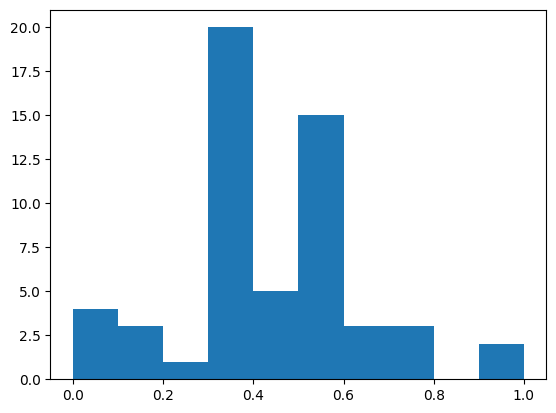

In [22]:
plt.hist(dataframe['HWQI'])

In [23]:
(dataframe).corrwith(dataframe['HWQI'])

<ipython-input-23-0036a586283d>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (dataframe).corrwith(dataframe['HWQI'])


pH             0.106968
Salinity       0.559821
Carbonate     -0.014115
BiCarbonate   -0.051408
Alkalinity    -0.010036
Hardness       0.433366
Calcium       -0.268119
Magnesium      0.457176
Ammonia        0.585113
Coincidence         NaN
B1            -0.494090
B10           -0.388352
B11           -0.323860
B12           -0.368513
B2            -0.551185
B3            -0.596716
B4            -0.556939
B5            -0.448563
B6            -0.405611
B7            -0.383047
B8            -0.440615
B8A           -0.398462
B9            -0.454930
WQI            0.436688
HWQI           1.000000
dtype: float64

MAE 0.12318718758377578
MSE 0.020119450836273735
RMSE 0.14184305001047368
MAPE 0.30348872567131285
R2 Score 0.28484028318838084
-----For WQI with pH Regression relation-----


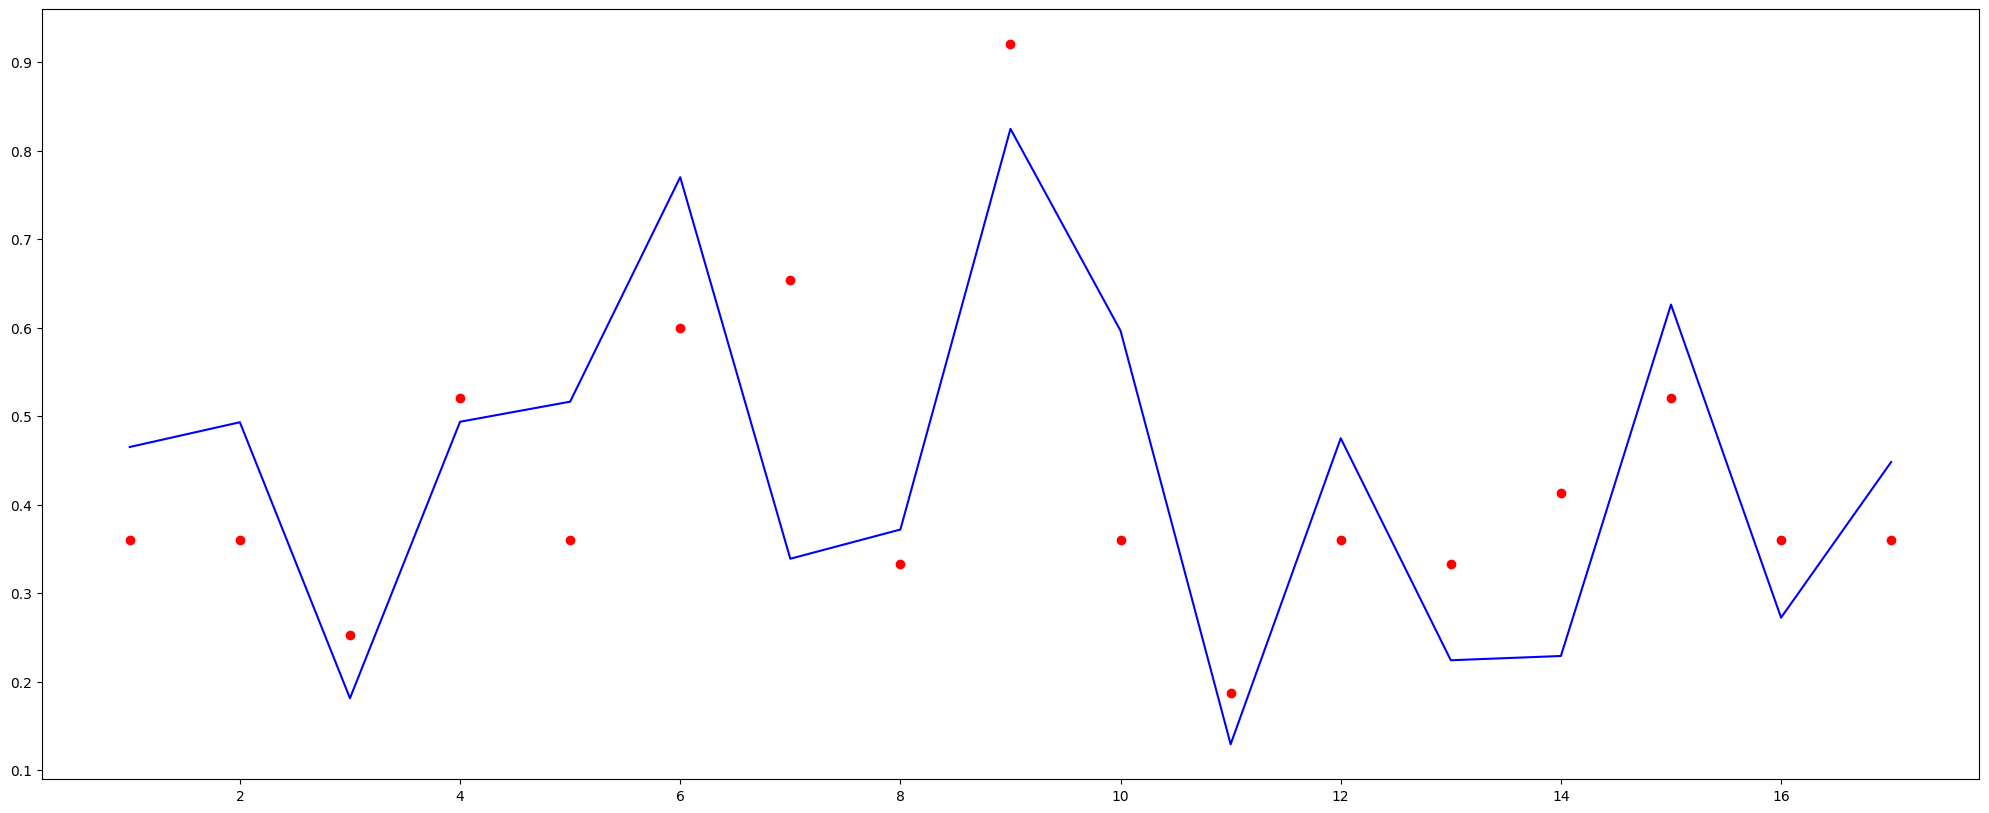

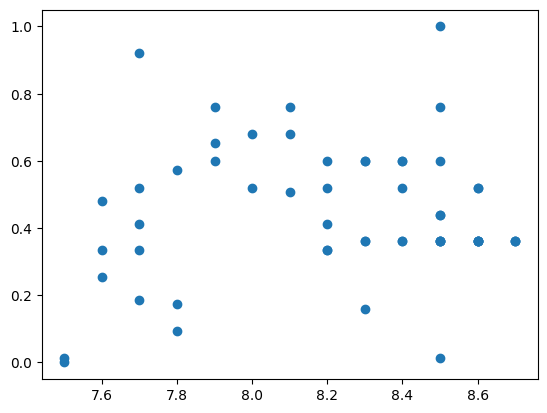

8.0 - 8.157301907152783
8.5 - 8.090540546978822
8.1 - 8.090540546978822
8.2 - 8.100628209316485
7.9 - 8.090540546978822
7.7 - 8.090540546978822
8.5 - 8.090540546978822
8.2 - 8.157301907152783
8.4 - 8.100628209316485
8.0 - 8.090540546978822
8.1 - 8.090540546978822
8.3 - 8.100628209316485
8.3 - 8.100628209316485
8.6 - 8.157301907152783
7.7 - 8.157301907152783
MAE 0.22712977438368256
MSE 0.07621255705791258
RMSE 0.2760662186105221
MAPE 0.027758056887331652
R2 Score -0.0650823191323191
validation results on pH
MAE 0.35262969355947776
MSE 0.15522432285689522
RMSE 0.3939851810117929
MAPE 0.042971571997568174
R2 Score 0.09337450877844111
8.4 - 8.177708355338465
8.6 - 8.160860553769325
7.6 - 7.859215865384617
8.4 - 8.165431982340754
8.6 - 8.157301907152783
8.3 - 8.090540546978822
7.9 - 7.967785476038391
7.7 - 8.508657308109935
7.7 - 8.090540546978822
8.5 - 8.100628209316485
7.7 - 7.919968029886783
8.7 - 8.160860553769325
7.6 - 7.85654919871795
7.7 - 7.85654919871795
8.6 - 8.100628209316485
8.4

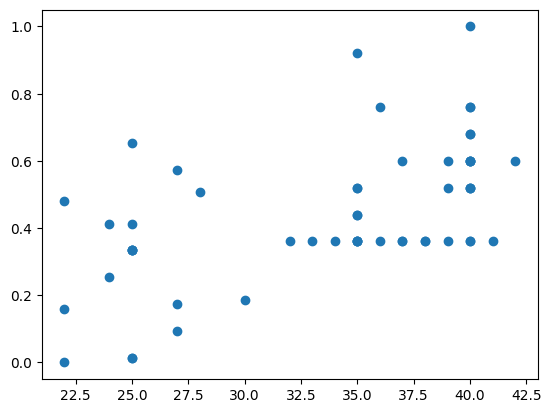

35 - 32.794667970918994
40 - 29.97797491092498
40 - 29.97797491092498
40 - 33.02761144423728
36 - 29.97797491092498
35 - 29.97797491092498
40 - 29.97797491092498
40 - 32.794667970918994
42 - 33.02761144423728
40 - 29.97797491092498
40 - 29.97797491092498
40 - 33.02761144423728
39 - 33.02761144423728
40 - 32.794667970918994
39 - 32.794667970918994
MAE 7.524337197526668
MSE 61.61968644325821
RMSE 7.84982079051861
MAPE 0.19075274016310986
R2 Score -14.68374372141753
validation results on Salinity
MAE 4.369225311857927
MSE 30.5911576421303
RMSE 5.530927376320386
MAPE 0.13097075068231065
R2 Score 0.04443962834244963
35 - 32.496838298417586
38 - 32.54445734603663
24 - 26.08156290931291
40 - 32.54445734603663
33 - 32.794667970918994
40 - 29.97797491092498
25 - 25.810869434359986
25 - 36.00858494839643
35 - 29.97797491092498
32 - 33.02761144423728
30 - 25.04540706515706
40 - 32.496838298417586
25 - 25.726241480741486
25 - 25.726241480741486
35 - 33.02761144423728
34 - 25.629120268620273
37 - 3

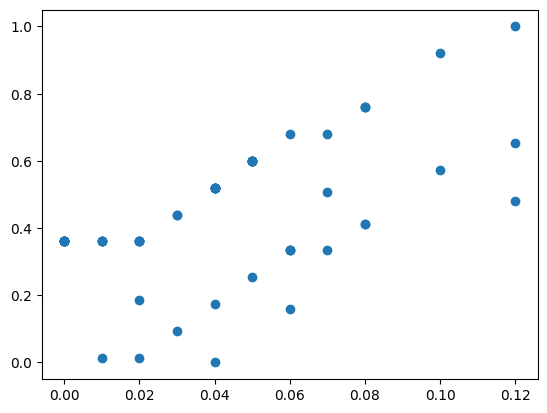

0.04 - 0.05981950005266489
0.08 - 0.0915725321900322
0.08 - 0.0915725321900322
0.05 - 0.06167239327055811
0.08 - 0.0915725321900322
0.1 - 0.0915725321900322
0.12 - 0.0915725321900322
0.04 - 0.05981950005266489
0.05 - 0.06167239327055811
0.07 - 0.0915725321900322
0.06 - 0.0915725321900322
0.05 - 0.06167239327055811
0.05 - 0.06167239327055811
0.04 - 0.05981950005266489
0.04 - 0.05981950005266489
MAE 0.01671234465753257
MSE 0.0003239561310416002
RMSE 0.01799878137657103
MAPE 0.30035130455600884
R2 Score 0.4168789641251196
validation results on Ammonia
MAE 0.0407431813746978
MSE 0.0021020692232694396
RMSE 0.04584832846756182
MAPE 68861353408072.2
R2 Score -0.654406333128726
0.0 - 0.06921560527594404
0.0 - 0.07009457220273706
0.05 - 0.041776536207988546
0.04 - 0.06292866671933156
0.02 - 0.05981950005266489
0.05 - 0.0915725321900322
0.12 - 0.041325172571624894
0.06 - 0.010692125369305834
0.1 - 0.0915725321900322
0.02 - 0.06167239327055811
0.02 - 0.041776536207988546
0.0 - 0.07009457220273706

In [24]:
predictedWQI,gtforRE = predictWQI(dataframe,"HWQI")
# WQIandParameters(np.array(predictedWQI).reshape(-1, 1),gtforRE)
WQIandParameters(dataframe,'HWQI',predictedWQI.reshape(-1, 1),gtforRE,scaler3)
# WQIandParameters(np.array(dataframe['HWQI']).reshape(-1, 1),dataframe[parameters],predictedWQI.reshape(-1, 1),gtforRE)

In [25]:
## Not good code

In [26]:


# #to train model to predict the WQI using band  indcies using ML
# def WQIandBands(df1,WQI):
#   print('-----For WQI prediction with Bands with SVR algo -----')
#   X_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['pH']]
#   X_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
#   y_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['pH']]
#   # X_train, X_test, y_train, y_test = train_test_split(Bandsndices, WQI, test_size=0.33, random_state=42)
#   model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
#   model.fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   return prediction


# def CM(actual, predicted):
#   fig = plt.figure()
#   plt.scatter(actual, predicted)
#   plt.show()

# def LRegression(WQI,GT):
#   X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
#   model = LinearRegression().fit(X_train, y_train)
#   # model1 = SVR(kernel='rbf', C=1.0, epsilon=0.2).fit(X_train, y_train)
#   # model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
#   prediction = model.predict(X_test)
#   for x,y in zip(y_test.values,prediction):
#     print(x,'-',y)

#   CM(WQI,GT)
#   print("MAE", mean_absolute_error(y_test, prediction))
#   print("MSE", mean_squared_error(y_test, prediction))
#   print("RMSE", mean_squared_error(y_test, prediction, squared=False))
#   print("MAPE", mean_absolute_percentage_error(y_test, prediction))
#   print("R2 Score", r2_score(y_test, prediction))
#   # return model.coef_,model.intercept_
# #to predict the parameters from WQI



# def WQIandParameters(WQI,GT):
#   print('-----For WQI with pH Regression relation-----')
#   LRegression(WQI,GT['pH'])
#   print('-----For WQI with Salinity  Regression relation-----')
#   LRegression(WQI,GT['Salinity'])
#   print('-----For WQI with Ammonia SVR relation-----')
#   LRegression(WQI,GT['Ammonia'])
#   return None



## WQI with only bands

In [27]:
# WQI = WQIcalculation(df1 ,GT1)
# # len(WQI)
# WQIandBands(df1,WQI)
# WQIandParameters(np.array(WQI).reshape(-1, 1),GT)

## WQI with  top  10 combination indices

In [28]:
#   corrwithWQI = newdf.corrwith(newdf['WQI_cal'])
# type(corrwithWQI)
# corrdict  = corrwithWQI.to_dict()
# sortedkeys = sorted(corrdict, key=corrdict.get, reverse=True)
# for r in sortedkeys[:11]:
#     print(r, corrdict[r])

In [29]:
# newtraindf = newdf[sortedkeys].drop('WQI_cal',axis = 1)
# scaler = StandardScaler()
# scaler.fit(newtraindf)
# newscaledtraindf = scaler.transform(newtraindf)
# WQIandBands(newscaledtraindf,WQI)

In [30]:
# plt.scatter(df['norm_NarrowNIR_SWIR1'],df['WQI_cal'])
# plt.scatter(df['norm_NarrowNIR_SWIR2'],df['WQI_cal'])
# plt.scatter(df['norm_WaterVapour_SWIR2'],df['WQI_cal'])

## WQI with  PCA 3 bands